In [2]:
%matplotlib inline

import numpy as np # NUMPY
import pandas as pd # PANDAS
import matplotlib.pyplot as plt # MATPLOTLIB
import seaborn as sns # SEABORN
import scipy
import sklearn
from sklearn.decomposition import PCA
import cv2
import os 
from skimage import filters
from scipy import ndimage

# Vamos a escribir un expression map, primero con us Self Organizing Map

In [11]:
from numpy import random 
 
x = np.arange(5)
y = np.arange(5)
xx, yy = np.meshgrid(x, y)
xx, xx[::2]

(array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]),
 array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]))

In [3]:
b_shape = pd.read_csv('pca_shapepoints.csv',header = None)
b_structure = pd.read_csv('pca_structurepoints.csv',header = None)
b_cartoon = pd.read_csv('pca_cartoonpoints.csv',header = None)
b_texture = pd.read_csv('pca_texturepoints.csv',header = None)

In [3]:
b_shape = pd.read_csv('pca_training_shapepoints.csv',header = None)
b_structure = pd.read_csv('pca_training_structurepoints.csv',header = None)
b_cartoon = pd.read_csv('pca_cartoontrainingpoints.csv',header = None)
b_texture = pd.read_csv('pca_texturetrainingpoints.csv',header = None)

In [4]:
len(b_cartoon)

689

estas 2 celdas están porque no tenemos todas las imagenes del conjunto de entrenamiento todavia

In [5]:
cant_frames_per_seq = pd.read_csv('cktraining_landmark_FramePerSeq.csv',header = None)
cant_frames_per_seq = np.asarray(cant_frames_per_seq).flatten()
cant_frames_per_seq

first_frames = [0]
for i in cant_frames_per_seq:
    current = first_frames[-1] + i
    first_frames.append(current)

In [6]:
first_frames[0:37]

[0,
 14,
 33,
 48,
 64,
 86,
 100,
 121,
 141,
 154,
 184,
 216,
 233,
 248,
 264,
 279,
 292,
 316,
 331,
 350,
 368,
 388,
 410,
 431,
 455,
 469,
 488,
 503,
 533,
 558,
 564,
 580,
 597,
 614,
 632,
 653,
 676]

In [7]:
b_shape = b_shape[0:689]
b_structure = b_structure[0:689]

In [8]:
b_vector = np.concatenate((b_shape, b_structure), axis = 1)
b_vector = np.concatenate((b_vector, b_cartoon), axis = 1)
b_vector = np.concatenate((b_vector, b_texture), axis = 1)

In [9]:
b_vector.shape

(689, 70)

In [10]:
def get_emotions(files):
    emotions = []
    for file in files:
        with open(file) as f:
            emotion = int(float(f.readline()))
            emotions.append(emotion)
    emotions = np.asarray(emotions)
    return emotions

In [111]:
import glob
my_path = '/home/alicia/Documentos/Tesis2023/SynthesisEmotions/ck+copytraining/Emotion_labels/Emotion'


emotions = []

files = np.sort(glob.glob(my_path + '/**/*.txt', recursive=True))
emotions = get_emotions(files)


In [12]:
def get_label_emotions(b_vector, seq_first_frames):
    b_vectors_labeled = []
    target = []
    for i in range(0,36):
        co = first_frames[i]
        sa = first_frames[i+1]
        b_vectors_labeled.append(b_vector[co])
        b_vectors_labeled.append(b_vector[sa-1])
        target.append(0)
        target.append(emotions[i])
    return b_vectors_labeled, target
    
    

In [20]:
b_vectors_labeled, target = get_label_emotions(b_vector, first_frames)

In [113]:
np.asarray(b_vectors_labeled).shape, np.asarray(target).shape

((72, 70), (72,))

In [130]:
odds = np.arange(1,72, step =2)
odds

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71])

In [133]:
#target[1::2] #all apex emotions in odd index

b_vectors_labeled = np.asarray(b_vectors_labeled)
apex_vector_trained_index = np.random.choice(odds, 17,replace=False )
apex_vector_trained_index

array([35, 43, 29, 65, 13, 47, 31, 39, 57, 67, 25, 45, 15,  3, 41, 49, 63])

Vamos a buscar las emociones labeleadas, son las numero 0 y 1



In [121]:
72/2

36.0

target son las neuronas 0 y 1 (inicio y fin de frames)


In [86]:
#Vamos a hacer varios minisom y conseguir los snapshots

stops = [10,  20, 30, 40, 50, 60, 80, 10]
stops

[10, 20, 30, 40, 50, 60, 80, 10]

In [108]:
import minisom

weights = {}
stops = [8000, 10000, 15000, 30000, 50000, 100000]

som = minisom.MiniSom(10,10,70,sigma=3,learning_rate=0.8)
som.random_weights_init(b_vector)
print("Training...")
som.train_random(b_vector,stops[0], verbose=False) # training with 100 iterations
print("\n...ready!")
weights[stops[0]] = som.get_weights()

for i in range(1, len(stops[1:])):
    som = minisom.MiniSom(10,10,70,sigma=3,learning_rate=0.8)
    key = stops[i-1] 
    som._weights = weights[key]
    print("Training...")
    som.train_random(b_vector,stops[i], verbose=False) # training with 100 iterations
    print("\n...ready!")
    weights[stops[i]] = som.get_weights()

Training...

...ready!
Training...

...ready!
Training...

...ready!
Training...

...ready!
Training...

...ready!


In [58]:
weights[4000].shape

(10, 10, 70)

In [32]:
suggeted_number =  5*np.sqrt(len(b_vector))
suggeted_number #11, we use 10

131.24404748406687

### El SOM normal


In [25]:
import minisom
### Initialization and training ###
som = minisom.MiniSom(10,10,70,sigma=2,learning_rate=0.2)#hay 8x8 neuronas(64)
som.random_weights_init(b_vector)
print("Training...")
som.train_random(b_vector,10000, verbose=True) # training with 100 iterations
print("\n...ready!")

Training...
 [ 30000 / 30000 ] 100% - 0:00:00 left 
 quantization error: 100.8385136870924

...ready!


In [26]:
som.topographic_error(b_vector)



0.03773584905660377

72


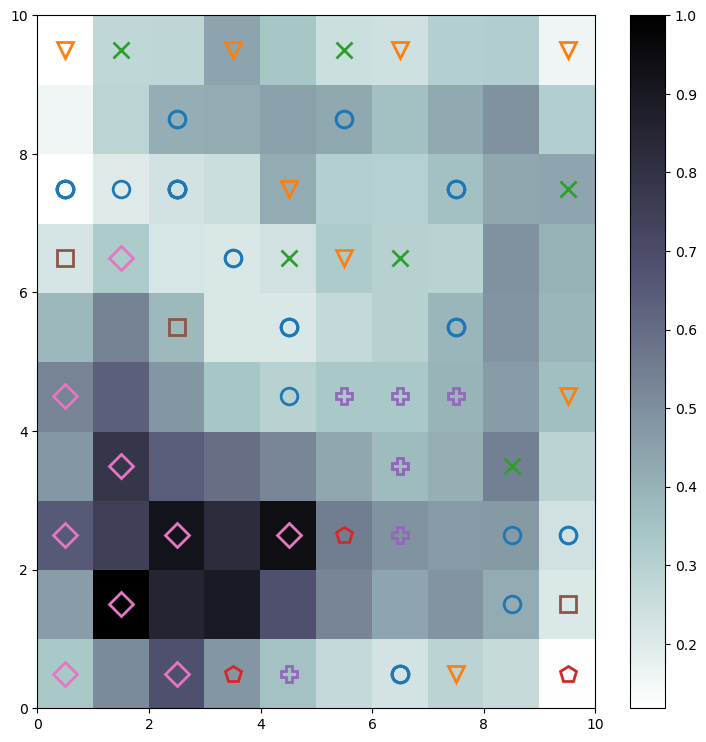

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()


## Plotting the response for each pattern in the iris dataset
## different colors and markers for each label
markers = ['o','v','NO', 'x', 'p', 'P','s','D' ]
colors = ['C0', 'C1', 'NO', 'C2', 'C3', 'C4','C5', 'C6']
for cnt, xx in enumerate(b_vectors_labeled):     
    w = som.winner(xx)  # getting the winner    
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor='None',
             markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)
print(len(b_vectors_labeled))
plt.show()

In [68]:
def get_labeled_neurons(labeled_vectors, emo_target, emptyDic, somap):
    dic = somap.win_map(labeled_vectors,return_indices=True )
    emotion_targets = emo_target
    counters = []
    for key in dic:
        space = np.zeros(len(dic[key]), dtype = int)
        for i in range(0, len(dic[key])):
            val = dic[key]       
            space[i] = emotion_targets[val[i]]
        counters.append(space)
    for cnt, key in enumerate(dic):
        emptyDic[key] = max(counters[cnt])    
    return 0

In [51]:
MyDic = {}    
a =get_labeled_neurons(b_vectors_labeled, target,MyDic  )


In [52]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
def draw_labeled_neurons_map(somap, MyDic,savepath, formato):
    plt.figure(figsize=(7,7))

    plt.pcolor(somap.distance_map().T, cmap='bone_r')  # plotting the distance map as background
    plt.colorbar()

    ## Plotting the response for each pattern in the iris dataset
    ## different colors and markers for each label
    blue_star = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                          markersize=10, label='Blue stars')
    red_square = mlines.Line2D([], [], color='orange', marker='v', linestyle='None',
                          markersize=10, label='Red squares')
    purple_triangle = mlines.Line2D([], [], color='green', marker='x', linestyle='None',
                          markersize=10, label='Purple triangles')
    green_star = mlines.Line2D([], [], color='red', marker='p', linestyle='None',
                          markersize=10, label='Blue stars')
    orange_square = mlines.Line2D([], [], color='purple', marker='P', linestyle='None',
                          markersize=10, label='Red squares')
    yellow_triangle = mlines.Line2D([], [], color='brown', marker='s', linestyle='None',
                          markersize=10, label='Purple triangles')
    black_triangle = mlines.Line2D([], [], color='pink', marker='D', linestyle='None',
                          markersize=10, label='Purple triangles')

    markersleg = [blue_star, red_square, purple_triangle, green_star, orange_square,yellow_triangle, black_triangle   ]

    #markers = [1,2,3,4,5,6,7]
    markers = ['o','v', 'x', 'p', 'P','s','D' ]
    colors = ['C0', 'C1', 'C2', 'C3', 'C4','C5', 'C6']
    lala = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sadness', 'Surprise', 'Neutral'] 
    for key in MyDic:
        # palce a marker on the winning position for the sample xx
        w = key  
        sign = MyDic[key]
        if sign > 2:#no hay labels 2 porque las filtramos al hacer la base de dates
            sign = sign -1
        plt.plot(w[0]+.5, w[1]+.5, markers[sign], markerfacecolor='None',
                 markeredgecolor=colors[sign], markersize=12, markeredgewidth=2)


    lgd = plt.legend(handles = markersleg, labels = lala, bbox_to_anchor=(0, 1), loc='upper right', ncol=1)

    plt.title('Clasificación del Expression Map')
    #b_tuple = tuple(map(tuple, b_vector))     
    plt.savefig(savepath,  bbox_extra_artists=(lgd,), bbox_inches='tight',format=formato)
    plt.show()
    return 0
    

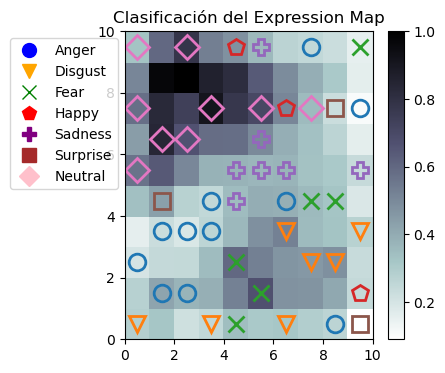

0

In [76]:
pathi = '/home/alicia/Documentos/Tesis2023/SynthesisEmotions/Notebook/expression_map_white3.png'
draw_labeled_neurons_map(som, MyDic, pathi, 'png')


#Vamos a hacer la imagen para cada som de los weigths (que son como snapshots de la evolucion del mapa)




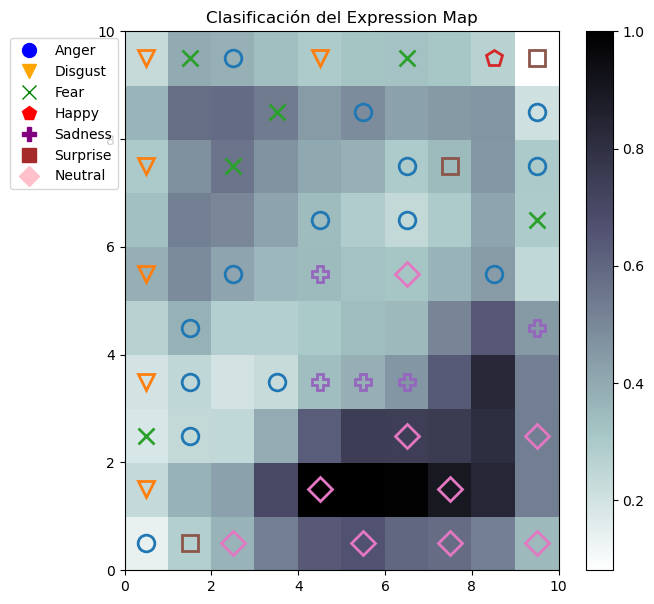

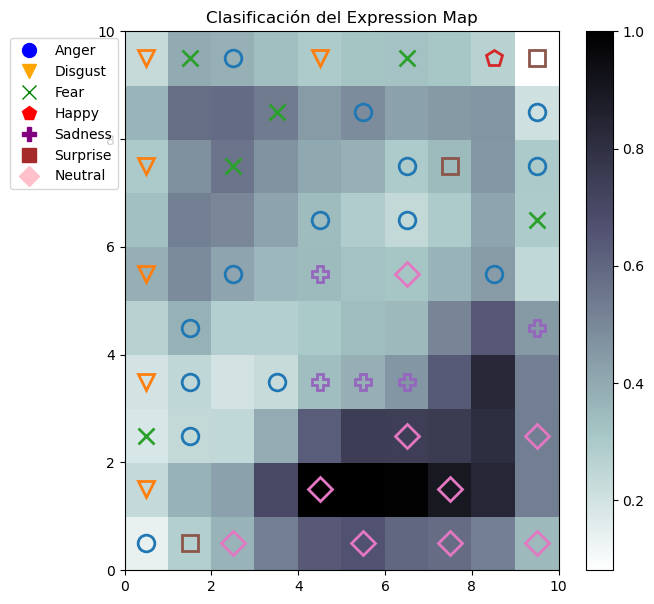

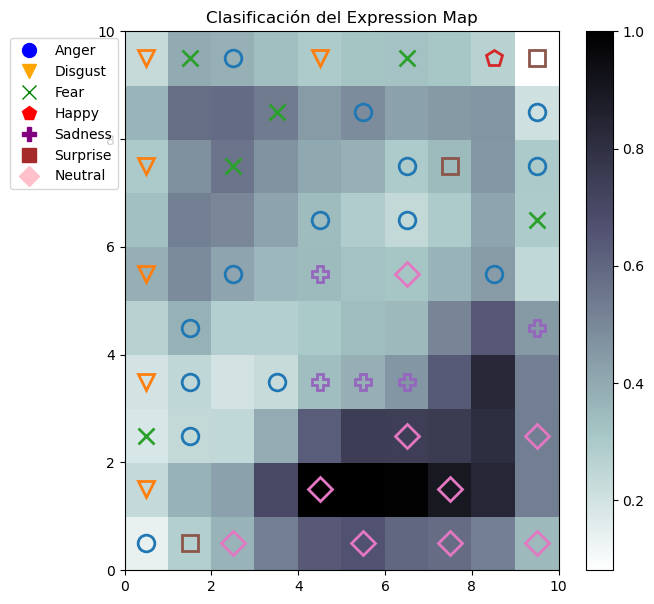

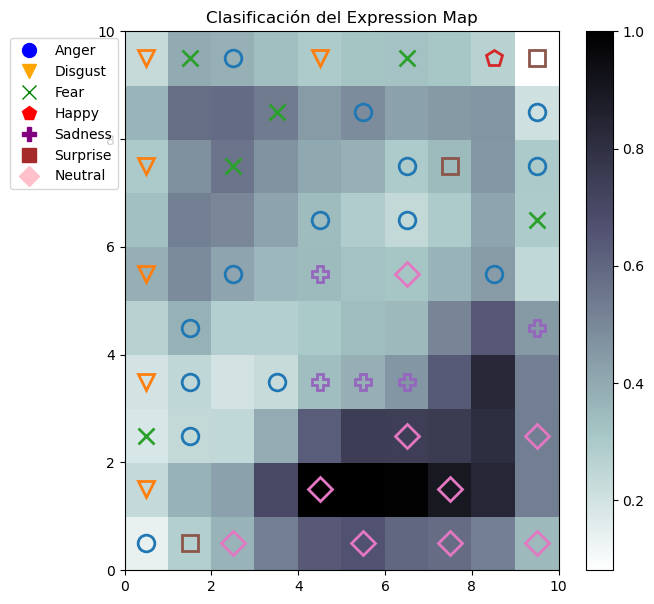

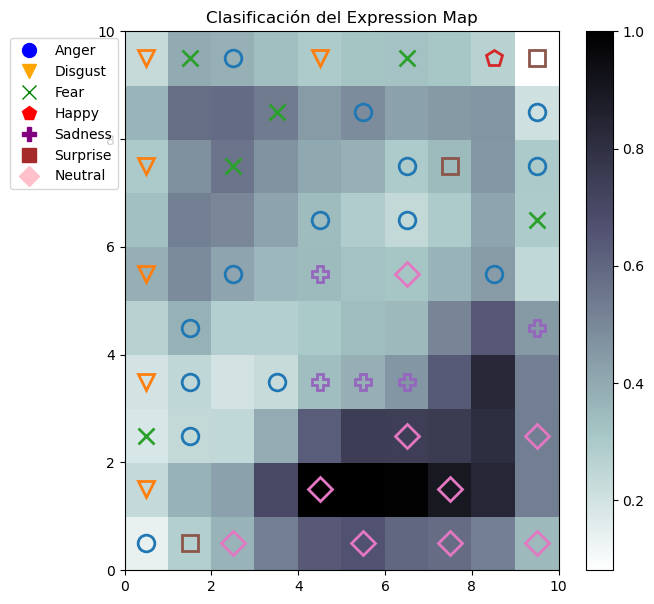

In [109]:
#generamos una instancia de som por cada parada, y luego la graficamos

for key in weights.keys():
    actual_weights = weights[key]
    som = minisom.MiniSom(10,10,70,sigma=3,learning_rate=0.8)#hay 8x8 neuronas(64)
    som._weights = weights[key]
    vectors_labeled, target = get_label_emotions(b_vector, first_frames)
    actual_labeledneurons_dic = {}
    get_labeled_neurons(vectors_labeled, target, actual_labeledneurons_dic, som)
    savepath = '/home/alicia/Documentos/Tesis2023/SynthesisEmotions/Notebook/expression_map_snapshot' +str(key) + '_white.png'
    draw_labeled_neurons_map(som, actual_labeledneurons_dic,savepath, 'png')
    
    

In [ ]:
#Vamos a ver la tasa de clasificación de secuencias normales 

#(agarro varias secuencias y miro que las cosas esten bien (que clasifique) )

In [146]:
b_vectors_labeled = np.asarray(b_vectors_labeled)
#target is high up
apex_vector_trained_index = np.random.choice(odds, 17,replace=False )
apex_vector_trained_index # target

actual_weights = weights[key]
som = minisom.MiniSom(10,10,70,sigma=3,learning_rate=0.8)#hay 8x8 neuronas(64)
som._weights = weights[50000]


actual_labeledneurons_dic = {}
get_labeled_neurons(vectors_labeled, target, actual_labeledneurons_dic, som)

correct_labels_quanti = 0

for i in apex_vector_trained_index:
    actual_emotion = target[i]
    winning_neuron = som.winner(b_vectors_labeled[i])
    labeled_emotion = actual_labeledneurons_dic[winning_neuron]
    if actual_emotion == labeled_emotion:
        correct_labels_quanti = correct_labels_quanti + 1
error_tass = 1- (correct_labels_quanti/len(apex_vector_trained_index))
        

In [147]:
error_tass

0.11764705882352944


Ahora vamos a tratar de, dado imagenes nuevas, clasificarlas en el som y que nos den la emocion correspondiente



In [58]:
mypath  = '/home/alicia/Documentos/Tesis2023/SynthesisEmotions/ck+copy/extended-cohn-kanade-images/cohn-kanade-images'

test_images_labels = {}
test_images = []

files = np.sort(glob.glob(mypath + '/**/*.png', recursive=True))
for file in files:    
    if int((os.path.splitext(file.split('_')[2])[0])) == 0:
        test_image_labels[file] = 0
    else:
        test_images.append(file)    
test_images = np.asarray(test_images)


In [59]:
    
subject_number = np.random.choice(test_images, 30, replace=False )
for i in subject_number:    
    sub, em = i.split('/')[9],i.split('/')[10]
    mypath = '/home/alicia/Documentos/Tesis2023/SynthesisEmotions/ck+copy/Emotion_labels/Emotion/'
    mypath = mypath + sub + '/' + em    
    files = np.sort(glob.glob(mypath + '/**/*.txt', recursive=True))   
    for file in files:
        with open(file) as f:
            emotion = int(float(f.readline()))
            test_images_labels[i] =emotion
test_images_labels #imagenes de prueba a las que le debemos sacar los vectores b

{'/home/alicia/Documentos/Tesis2023/SynthesisEmotions/ck+copy/extended-cohn-kanade-images/cohn-kanade-images/S100/002/S100_002_00000012.png': 7,
 '/home/alicia/Documentos/Tesis2023/SynthesisEmotions/ck+copy/extended-cohn-kanade-images/cohn-kanade-images/S127/004/S127_004_00000016.png': 5,
 '/home/alicia/Documentos/Tesis2023/SynthesisEmotions/ck+copy/extended-cohn-kanade-images/cohn-kanade-images/S063/002/S063_002_00000002.png': 5,
 '/home/alicia/Documentos/Tesis2023/SynthesisEmotions/ck+copy/extended-cohn-kanade-images/cohn-kanade-images/S014/005/S014_005_00000006.png': 5,
 '/home/alicia/Documentos/Tesis2023/SynthesisEmotions/ck+copy/extended-cohn-kanade-images/cohn-kanade-images/S029/001/S029_001_00000018.png': 1,
 '/home/alicia/Documentos/Tesis2023/SynthesisEmotions/ck+copy/extended-cohn-kanade-images/cohn-kanade-images/S071/002/S071_002_00000012.png': 6,
 '/home/alicia/Documentos/Tesis2023/SynthesisEmotions/ck+copy/extended-cohn-kanade-images/cohn-kanade-images/S091/001/S091_001_000

In [68]:
#Tenemos que hacer los shape de forma, estructura, y textura.

#Forma -> tenemos que alinear landmarks a reference shape

#Primero encontramos los landmarks
import dlib

image_landmarks = {}


face_detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

for key in test_images_labels:
    subject_image = key
    img = cv2.imread(subject_image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    coordinate_boxes = face_detector(gray, 1)
    face_landmark_got_points = []
    for c in coordinate_boxes:
        x_init, y_init, x_fin, y_fin = c.left(), c.top(), c.right(), c.bottom()
        cv2.rectangle(img, (x_init, y_init), (x_fin, y_fin), (0,255,0),1)    
        shape = predictor(gray, c)
        for i in range(0,68):
            x, y = shape.part(i).x, shape.part(i).y
            face_landmark_got_points.append(np.asarray([x,y]))
            cv2.circle(img, (x,y), 2, (255,0,0),-1)    
    face_landmark_got_points = np.asarray(face_landmark_got_points)
    image_landmarks[key]= face_landmark_got_points




In [ ]:
#ahora tenemos que alinear los landmarks con la reference shape y transformar las imagenes

In [78]:

        
def opa(a, b):# a, b matrices de puntos [[],[],[]] a and b need to have same dimension
    aT = a.mean(0) # column mean [[1,2,3],[1,2,3]]<-(1,2,3)
    bT = b.mean(0)
    A = a - aT  #We rest aT and bT to center the matrix (translation)
    B = b - bT
    aS = np.sum(A * A)**.5 #to see the scale, we first calculate square of squared sum
    bS = np.sum(B * B)**.5
    A /= aS  #we standarize the scale.
    B /= bS
    U, _, V = np.linalg.svd(np.dot(B.T, A)) # we get the principal values of the mult for getting the rotation more close 
    aR = np.dot(U, V) #<-the rotation matrix is the multiplication of these 2
    if np.linalg.det(aR) < 0: # we rotate to the positive side
        V[1] *= -1
        aR = np.dot(U, V)
    aS = aS / bS  #to scale A most similar to B, we divide the scale by sSvale
    aT-= (bT.dot(aR) * aS) #to get the translation in B coordinates, rest b mean rotated to A, and scaled to A 
    aD = (np.sum((A - B.dot(aR))**2) / len(a))**.5  # the square distance (error)of the A and B rotated after scale and translation
    return aR, aS, aT, aD #return aROtation, aScale, aTranslation, Adifference


In [79]:
import matplotlib.cm as cm 
my_landmarks = pd.read_csv('cktraining_landmark_intercalated_data.csv',header = None)

path = '../ck+copytraining/extended-cohn-kanade-images/cohn-kanade-images/'

images = [f for f in glob.glob(path + "**/*.png", recursive=True)]

images = np.sort(np.asarray(images))
print(images.shape)





#esta es la imagen de referencia
even = np.asarray(my_landmarks.iloc[0][::2] )
odds = np.asarray( my_landmarks.iloc[0][1::2] )
target_X_img = cv2.imread(images[0],0)
lan =[]
for (a, b) in zip(even, odds):
    lan.append(np.asarray([a,b]))
lan = np.asarray(lan)


(3614,)


In [53]:
som.get_weights().shape # las weights finales son los patterns



(10, 10, 70)

In [54]:
np.save('expmaptest2.npy', som.get_weights(), allow_pickle=False)

np.save('expmaplabels2.npy', MyDic)

In [ ]:
surprise
sadness
fear
anger
disgust
happiness
surprise
sadness
disgust

In [139]:
According to ck+

Anger = 1
Contempt = 2 (no vemos)
Disgust = 3
Fear = 4
Happy = 5
Sadness =6
Surprise =  7

SyntaxError: invalid syntax (1089313241.py, line 1)

In [138]:
som.values

AttributeError: 'MiniSom' object has no attribute 'values'